Use the combined data from all homes during a month to estimate an average energy use per month. All readings for one month are essentially treated as coming from one single home and are then used to sample the estimate. Which homes are used for which month is determined by the availability of the respective file. If the file for a home for the respective month is available, it is used. If not, it is ignored. These files are created by the notebook 01.1 -.... If readings for a home for a month are available (irrespective of the period, i.e. baseline or not) the file is created otherwise nothing is done.

In [ ]:
# << Can you mention in the above text - where it says which homes are used, it is just using data from the baseline period for each home, is that true? 
# I've added a sentence above. For the baseline estimation all data is taken together, i.e. no matter the 
# period (baseline or not).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '../src')

import re
import pickle
import datetime

import numpy as np
import pandas as pd

import seaborn as sns

from pathlib import Path
from multiprocessing import Pool
from functools import partial

from config import SENSOR_DATA_FOLDER, CACHE_FOLDER, EVALUATION_PERIOD, CPU_HIGH_MEMMORY, CPU_LOW_MEMMORY
from config import N_SAMPLES_BASELINE_SEASONAL, SAMPLING_WINDOW_BASELINE
from config import SAMPLING_MASK
from utils import treatment_control
from sampling import data_to_sample_array, sample_energy

In [3]:
# Run plotting styles
%run -i '../src/sns_styles.py'

cmap = sns.color_palette()

In [4]:
df_group = treatment_control()

df_group.tail()

,homeid,group,start_date,end_date
263,331,treatment,2018-05-15,2018-06-30
264,332,treatment,2018-05-15,2018-06-30
265,334,control,2018-05-15,2018-06-30
266,335,treatment,2018-05-15,2018-06-30
267,333,control,2018-05-15,2018-06-30


In [5]:
homeid_control = df_group.loc[df_group['group'] == 'control','homeid']
homeid_treatment = df_group.loc[df_group['group'] == 'treatment','homeid']
homeid_enhanced = df_group.loc[df_group['group'] == 'enhanced','homeid']

print('Found {} homes in the control group'.format(len(homeid_control)))
print('Found {} homes in the treatment group'.format(len(homeid_treatment)))
print('Found {} homes in the enhanced group'.format(len(homeid_enhanced)))

Found 107 homes in the control group
Found 106 homes in the treatment group
Found 39 homes in the enhanced group


In [6]:
# This is were the data will be stored
fpath = CACHE_FOLDER / Path('seasonal_background_estimate/')

if not fpath.is_dir():
    raise IOError('Cache files not found.')

# The filename for each individual array
fname = lambda homeid, month: fpath / Path('sample_array_homeid{}_month{}.npz'.format(homeid, month))

def load_array(month, homeids, fpath):
    # Get the list of files to load. This uses a regular expression to match all files
    # for the respective month. These are then used as input
    regexp = re.compile('sample_array_homeid({})_month{}.npz'.format('|'.join(homeids), month))
    fnames = [ f for f in fpath.glob('sample_array_homeid*_month*.npz') if regexp.search(f.name) ] 

    # Load the arrays and combine them 'along the rows', that is the number of rows
    # stays the same and the number of columns is the sum of the individual arrays.
    arr = np.concatenate([ np.load(f)['arr'] for f in fnames ], axis=1)
    
    # Combining several arrays will introduce NaN which are not always 'on the right'.
    # This won't work with the sampling approach so they will need to be 'sorted away'.
    # Sorting the whole array will put the NaNs last.
    arr.sort(axis=1)
    
    # The following is identical with the part in data_to_sample_array() in sampling.py
    # We've sorted the values above. It shouldn't matter, but to be safe, shuffle them again
    def f(x):
        idx = np.isfinite(x)
        x[idx] = np.random.permutation(x[idx])
        return x

    arr = np.apply_along_axis(f, axis=1, arr=arr)

    # Get last index per row for which the value is valid, i.e. after that only NaNs are found
    # and convert to count (i.e. add +1)
    idx = np.where(np.isfinite(arr))
    idx = pd.DataFrame({'row': idx[0], 'column': idx[1]}).groupby('row').max()
    idx += 1 # convert from index based to counts
    idx = idx.reindex(np.arange(arr.shape[0]), fill_value=0).values
    assert idx.shape[0] == arr.shape[0]

    # Depending on the data quality there might not be readings for every second. This will lead
    # to NaN values on the 'right' side of the array (due to sorting them). We can thus 'cut' all
    # columns with all NaNs
    arr = arr[:, :idx.max()]
    
    return arr, idx

In [7]:
def sample_energy_month(month, N, homeids, fpath, window_width):
    # Load the cached data for the month. If no data for a home in homeids is present it will be ignored silently.
    arr, idx = load_array(month, homeids, fpath)
    
    # Compute the number of samples per time point including the sampling window. This is a bit of a work
    # around. idx as returned above contains the number of samples per row of arr. With a window_width larger
    # zero, this will not be representative of the number of samples that can actually be drawn from. This bit
    # Here will thus compute the actual count of available samples which will then only be used to assert that
    # there are actually enough samples.
    if window_width is not None:
        assert window_width >= 0
        # Add the count of the additional rows that are used for sampling. In a first step, the idx vector is
        # shifted by the window width and in a second step all values (the shifted ones) are summed together.
        # For example, say idx = [1, 4, 2] and window_width should be 1.
        #
        #                           1     2     4     7
        # -> idx_sampling_window = (4) + (1) + (2) = (7)
        #                           2     4     1     7
        #
        # Note how the edge cases are flipped around. This is what we expect since the first value is at
        # midnight and the last value one step before midnight.
        idx_sampling_window = np.concatenate([np.roll(idx, shift, axis=0) for shift in range(-window_width, window_width + 1)], axis=1)
        idx_sampling_window = idx_sampling_window.sum(axis=1)
    else:
        idx_sampling_window = deepcopy(idx)
        
    # Sample the estimates
    estimates = [np.nan, ]
    if any(idx_sampling_window == 0):
        print('Not enough readings found for each time point in month {}.'.format(month))
    else:
        estimates = sample_energy(N, arr, idx, SAMPLING_MASK, window_width=window_width)
    return estimates

## Control group

In [8]:
# Set up the function for multiprocessing.
# partial() fixes the arguments of a function (here sample_energy_month) so that the new function takes
# fewer arguments. In this case there is only one left. This works then nicely with multiprocessing.pool
# << Typo on the line below. (should be corrected now)
# which expects one argument to pass to the function that should be evaluated for multiple arguments on
# multiple cores.
func = partial(sample_energy_month, N=N_SAMPLES_BASELINE_SEASONAL, homeids=list(homeid_control), fpath=fpath,
               window_width=SAMPLING_WINDOW_BASELINE)

print('Computing the estimates for each month. This may take a while..')
with Pool(processes=CPU_LOW_MEMMORY) as pool:
    estimates_control = pool.map(func, list(range(1,13)))
print('Done.')

Computing the estimates for each month. This may take a while..
Done.


## Treatment group

In [9]:
# Set up the function for multiprocessing
func = partial(sample_energy_month, N=N_SAMPLES_BASELINE_SEASONAL, homeids=list(homeid_treatment), fpath=fpath,
               window_width=SAMPLING_WINDOW_BASELINE)

print('Computing the estimates for each month. This may take a while..')
with Pool(processes=CPU_LOW_MEMMORY) as pool:
    estimates_treatment = pool.map(func, list(range(1,13)))
print('Done.')

Computing the estimates for each month. This may take a while..
Done.


## Enhanced group

In [10]:
# Set up the function for multiprocessing
func = partial(sample_energy_month, N=N_SAMPLES_BASELINE_SEASONAL, homeids=list(homeid_enhanced), fpath=fpath,
               window_width=SAMPLING_WINDOW_BASELINE)

print('Computing the estimates for each month. This may take a while..')
with Pool(processes=CPU_LOW_MEMMORY) as pool:
    estimates_enhanced = pool.map(func, list(range(1,13)))
print('Done.')

Computing the estimates for each month. This may take a while..
Done.


## Combined

Plot the energy estimates for the three groups. The shaded area is three times the standard deviation.

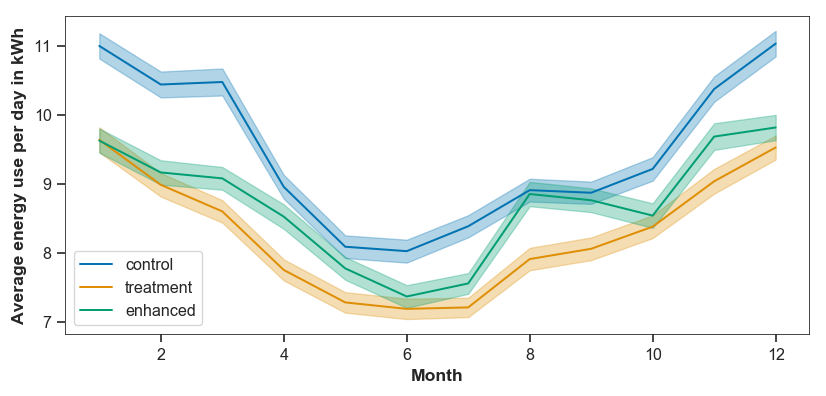

In [11]:
fig, ax = plt.subplots()

x = np.arange(1,13)

# Plot the control group
means_control = np.array([ np.mean(e) for e in estimates_control])
stds_control = np.array([ np.std(e) for e in estimates_control])

ax.plot(x, means_control, color=cmap[0], label='control')
ax.fill_between(x, means_control-3*stds_control, means_control+3*stds_control, alpha=0.3, color=cmap[0])

# Plot the treatment group
means_treatment = np.array([ np.mean(e) for e in estimates_treatment])
stds_treatment = np.array([ np.std(e) for e in estimates_treatment])

ax.plot(x, means_treatment, color=cmap[1], label='treatment')
ax.fill_between(x, means_treatment-3*stds_treatment, means_treatment+3*stds_treatment, alpha=0.3, color=cmap[1])

# Plot the enhanced group
means_enhanced = np.array([ np.mean(e) for e in estimates_enhanced])
stds_enhanced = np.array([ np.std(e) for e in estimates_enhanced])

ax.plot(x, means_enhanced, color=cmap[2], label='enhanced')
ax.fill_between(x, means_enhanced-3*stds_enhanced, means_enhanced+3*stds_enhanced, alpha=0.3, color=cmap[2])

ax.legend()

ax.set_ylabel('Average energy use per day in kWh')
ax.set_xlabel('Month');

In [12]:
# Write the result of the control group to disk
fname = '../data/energy_baseline_seasonal_trend.csv'

df = pd.DataFrame({'Month':np.arange(1,13), 'Mean':means_control, 'Std':stds_control})
df.to_csv(fname, sep='\t', float_format='%.3f', index=False)